#### Import Function

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
import joblib
import copy

# modelling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# cross validation using statsmodel prepartion
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate, KFold

# directory
import os
import datetime

# Pandas and setting visual
pd.set_option("display.max_columns", None)
plt.style.use('bmh')
sns.set()

!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter nbextension enable --py --sys-prefix output_scroll

import ipywidgets as widgets
from IPython.display import display

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing



In [2]:
# To save data

def pickle_load(file_path: str):
    # Load and return pickle file
    return joblib.load(file_path)

def pickle_dump(data, file_path: str) -> None:
    # Dump into file
    joblib.dump(data, file_path)

In [3]:
# Create Print_Coef_Std function
def print_coef_std(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    : param result: <statmodels RegressionResultWrapper> OLS Regression results from
    : return df: <pandas DataFrame>
    """
    coef = results.params
    std_error = results.bse

    df = pd.DataFrame(data = np.transpose([coef,std_error]),
                    index = coef.index,
                    columns = ["coef","std_error"])

    return df    

In [4]:
# Create StatsmodelsRegressor and kfold_split function
class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A Universal sklearn-type wrapper for statsmodels regressor """

    def __init__(self, sm_class, sm_formula) -> None:
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None

    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()

    def predict(self, X):
        return self.result.predict(X)
    
def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficient and Standard Error in on DataFrame
    """

    kfold = KFold(n_splits= n_fold,
                  shuffle= True,
                  random_state= 123)
    fold_train = {}
    fold_test = {}

    for i, (train,test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()

    return (fold_train, fold_test)

## **Health Provider**
---

## **1. Load Data**
---

In [5]:
benefit = pd.read_csv("Train_Beneficiarydata-1542865627584.csv")

In [6]:
benefit.head(10)

BeneID         DOB         DOD  Gender  Race RenalDiseaseIndicator   
0  BENE11001  1943-01-01         NaN       1     1                     0  \
1  BENE11002  1936-09-01         NaN       2     1                     0   
2  BENE11003  1936-08-01         NaN       1     1                     0   
3  BENE11004  1922-07-01         NaN       1     1                     0   
4  BENE11005  1935-09-01         NaN       1     1                     0   
5  BENE11006  1976-09-01         NaN       2     1                     0   
6  BENE11007  1940-09-01  2009-12-01       1     2                     0   
7  BENE11008  1934-02-01         NaN       2     1                     0   
8  BENE11009  1929-06-01         NaN       1     1                     Y   
9  BENE11010  1936-07-01         NaN       2     1                     0   

   State  County  NoOfMonths_PartACov  NoOfMonths_PartBCov   
0     39     230                   12                   12  \
1     39     280                   12                   12   
2     52     590                   12                   12   
3     39     270                   12                   12   
4     24     680                   12                   12   
5     23     810                   12                   12   
6     45     610                   12                   12   
7     15     140                   12                   12   
8     44     230                   12                   12   
9     41      30                   12                   12   

   ChronicCond_Alzheimer  ChronicCond_Heartfailure  ChronicCond_KidneyDisease   
0                      1                         2                          1  \
1                      2                         2                          2   
2                      1                         2                          2   
3                      1                         1                          2   
4                      2                         2                          2   
5                      2                         2                          2   
6                      1                         1                          2   
7                      2                         2                          2   
8                      2                         1                          2   
9                      2                         1                          2   

   ChronicCond_Cancer  ChronicCond_ObstrPulmonary  ChronicCond_Depression   
0                   2                           2                       1  \
1                   2                           2                       2   
2                   2                           2                       2   
3                   2                           2                       2   
4                   2                           1                       2   
5                   2                           2                       2   
6                   2                           2                       2   
7                   2                           2                       2   
8                   2                           2                       2   
9                   1                           1                       2   

   ChronicCond_Diabetes  ChronicCond_IschemicHeart  ChronicCond_Osteoporasis   
0                     1                          1                         2  \
1                     2                          2                         2   
2                     2                          1                         2   
3                     1                          1                         1   
4                     1                          2                         2   
5                     2                          2                         2   
6                     1                          2                         1   
7                     1                          2                         2   
8                     1   

In [8]:
benefit.info
()

()

In [9]:
benefit.isna().any()

BeneID                             False
DOB                                False
DOD                                 True
Gender                             False
Race                               False
RenalDiseaseIndicator              False
State                              False
County                             False
NoOfMonths_PartACov                False
NoOfMonths_PartBCov                False
ChronicCond_Alzheimer              False
ChronicCond_Heartfailure           False
ChronicCond_KidneyDisease          False
ChronicCond_Cancer                 False
ChronicCond_ObstrPulmonary         False
ChronicCond_Depression             False
ChronicCond_Diabetes               False
ChronicCond_IschemicHeart          False
ChronicCond_Osteoporasis           False
ChronicCond_rheumatoidarthritis    False
ChronicCond_stroke                 False
IPAnnualReimbursementAmt           False
IPAnnualDeductibleAmt              False
OPAnnualReimbursementAmt           False
OPAnnualDeductib

In [10]:
benefit.duplicated().sum()

0

In [11]:
benefit.shape

(138556, 25)

In [12]:
print("We can ignored DOD column with missed value since DOD is Death of Death itself")
print("="*60)
print("There's no duplicated value also")

We can ignored DOD column with missed value since DOD is Death of Death itself
There's no duplicated value also


In [13]:
for col in benefit.columns.to_list():
    print(benefit[col].value_counts())

BeneID
BENE11001     1
BENE109830    1
BENE109844    1
BENE109843    1
BENE109842    1
             ..
BENE60463     1
BENE60461     1
BENE60460     1
BENE60459     1
BENE159198    1
Name: count, Length: 138556, dtype: int64
DOB
1939-10-01    540
1941-10-01    538
1939-03-01    535
1940-03-01    526
1939-04-01    517
             ... 
1983-03-01      9
1974-04-01      9
1979-08-01      8
1978-11-01      7
1983-02-01      7
Name: count, Length: 900, dtype: int64
DOD
2009-12-01    182
2009-10-01    168
2009-09-01    164
2009-11-01    149
2009-08-01    144
2009-07-01    141
2009-05-01    119
2009-06-01    119
2009-04-01     94
2009-03-01     91
2009-02-01     50
Name: count, dtype: int64
Gender
2    79106
1    59450
Name: count, dtype: int64
Race
1    117057
2     13538
3      5059
5      2902
Name: count, dtype: int64
RenalDiseaseIndicator
0    118978
Y     19578
Name: count, dtype: int64
State
5     12052
10     9771
45     8780
33     8443
39     6055
14     5923
36     5366
23     529

## **2. Handling Data**
---

Change Datetime data and calculate Age
<br>Change Int Data into Categorical Data such as ChronicCond_ data
<br>

#### **2.1 Add Age Columns**

In [14]:
# Add Age Column by datediff today - DOB
benefit["DOB"] = pd.to_datetime(benefit["DOB"], format= "%Y-%m-%d")
benefit["DOD"] = pd.to_datetime(benefit["DOD"], format= "%Y-%m-%d")

def calculate_age(born):
    today = datetime.date.today()
    age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    return age

benefit["Age"] =  benefit["DOB"].apply(calculate_age)

In [15]:
benefit.describe()

DOB                            DOD   
count                         138556                           1421  \
mean   1936-04-30 16:46:00.772539520  2009-07-27 22:27:46.995073792   
min              1909-01-01 00:00:00            2009-02-01 00:00:00   
25%              1928-01-01 00:00:00            2009-06-01 00:00:00   
50%              1935-09-01 00:00:00            2009-08-01 00:00:00   
75%              1941-12-01 00:00:00            2009-10-01 00:00:00   
max              1983-12-01 00:00:00            2009-12-01 00:00:00   
std                              NaN                            NaN   

              Gender           Race          State         County   
count  138556.000000  138556.000000  138556.000000  138556.000000  \
mean        1.570932       1.254511      25.666734     374.424745   
min         1.000000       1.000000       1.000000       0.000000   
25%         1.000000       1.000000      11.000000     141.000000   
50%         2.000000       1.000000      25.000000     340.000000   
75%         2.000000       1.000000      39.000000     570.000000   
max         2.000000       5.000000      54.000000     999.000000   
std         0.494945       0.717007      15.223443     266.277581   

       NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer   
count        138556.000000        138556.000000          138556.000000  \
mean             11.907727            11.910145               1.667817   
min               0.000000             0.000000               1.000000   
25%              12.000000            12.000000               1.000000   
50%              12.000000            12.000000               2.000000   
75%              12.000000            12.000000               2.000000   
max              12.000000            12.000000               2.000000   
std               1.032332             0.936893               0.470998   

       ChronicCond_Heartfailure  ChronicCond_KidneyDisease   
count             138556.000000              138556.000000  \
mean                   1.506322                   1.687643   
min                    1.000000                   1.000000   
25%                    1.000000                   1.000000   
50%                    2.000000                   2.000000   
75%                    2.000000                   2.000000   
max                    2.000000                   2.000000   
std                    0.499962                   0.463456   

       ChronicCond_Cancer  ChronicCond_ObstrPulmonary  ChronicCond_Depression   
count       138556.000000               138556.000000           138556.000000  \
mean             1.880041                    1.762847                1.644476   
min              1.000000                    1.000000                1.000000   
25%              2.000000                    2.000000                1.000000   
50%              2.000000                    2.000000                2.000000   
75%              2.000000                    2.000000                2.000000   
max              2.000000                    2.000000                2.000000   
std              0.324914                    0.425339                0.478674   

       ChronicCond_Diabetes  ChronicCond_IschemicHeart   
count         138556.000000              138556.000000  \
mean               1.398142                   1.324143   
min                1.000000                   1.000000   
25%                1.000000                   1.000000   
50%                1.000000                   1.000000   
75%                2.000000                   2.000000   
max                2.000000                   2.000000   
std                0.489517                   0.468056   

       ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis   
count             138556.000000                    138556.000000  \
mean                   1.725317                         1.743180   
min                    1.000000                         1.000000   
25%                 

#### **2.2 Drop Unnecessary Columns**

We aren't using few column to find correlation or relationship such as **BeneID**, **State**, **Country**, **NoOfMonths_PartACov**, **NoOfMonths_PartBCov**
<br> We can drop the columns

In [16]:
benefit.drop(columns=(["BeneID","State","County","NoOfMonths_PartACov","NoOfMonths_PartBCov"]), inplace=True)

In [17]:
benefit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   DOB                              138556 non-null  datetime64[ns]
 1   DOD                              1421 non-null    datetime64[ns]
 2   Gender                           138556 non-null  int64         
 3   Race                             138556 non-null  int64         
 4   RenalDiseaseIndicator            138556 non-null  object        
 5   ChronicCond_Alzheimer            138556 non-null  int64         
 6   ChronicCond_Heartfailure         138556 non-null  int64         
 7   ChronicCond_KidneyDisease        138556 non-null  int64         
 8   ChronicCond_Cancer               138556 non-null  int64         
 9   ChronicCond_ObstrPulmonary       138556 non-null  int64         
 10  ChronicCond_Depression           138556 non-

In [18]:
benefit_col = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
        'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
        'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
        'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
        'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
        'ChronicCond_stroke','RenalDiseaseIndicator','Gender','Race']

benefit_col

['ChronicCond_Alzheimer',
 'ChronicCond_Heartfailure',
 'ChronicCond_KidneyDisease',
 'ChronicCond_Cancer',
 'ChronicCond_ObstrPulmonary',
 'ChronicCond_Depression',
 'ChronicCond_Diabetes',
 'ChronicCond_IschemicHeart',
 'ChronicCond_Osteoporasis',
 'ChronicCond_rheumatoidarthritis',
 'ChronicCond_stroke',
 'RenalDiseaseIndicator',
 'Gender',
 'Race']

In [19]:
for col in benefit_col:
    benefit[col] = benefit[col].astype("object")

#### **2.3 Handling Data Type**

In [20]:
benefit["Race"].value_counts()

Race
1    117057
2     13538
3      5059
5      2902
Name: count, dtype: int64

In [21]:
benefit["RenalDiseaseIndicator"] = benefit["RenalDiseaseIndicator"].replace({"0":"No","Y":"Yes"})
benefit["Gender"] = benefit["Gender"].replace({1:"Female",2:"Male"})
benefit["Race"] = benefit["Race"].replace({1:"1", 2:"2", 3:"3", 5:"5"})

for col in benefit_col:
    benefit[col] = benefit[col].replace({1:"Yes",2:"No"})

In [22]:
benefit.head(10)

DOB        DOD  Gender Race RenalDiseaseIndicator   
0 1943-01-01        NaT  Female    1                    No  \
1 1936-09-01        NaT    Male    1                    No   
2 1936-08-01        NaT  Female    1                    No   
3 1922-07-01        NaT  Female    1                    No   
4 1935-09-01        NaT  Female    1                    No   
5 1976-09-01        NaT    Male    1                    No   
6 1940-09-01 2009-12-01  Female    2                    No   
7 1934-02-01        NaT    Male    1                    No   
8 1929-06-01        NaT  Female    1                   Yes   
9 1936-07-01        NaT    Male    1                    No   

  ChronicCond_Alzheimer ChronicCond_Heartfailure ChronicCond_KidneyDisease   
0                   Yes                       No                       Yes  \
1                    No                       No                        No   
2                   Yes                       No                        No   
3                   Yes                      Yes                        No   
4                    No                       No                        No   
5                    No                       No                        No   
6                   Yes                      Yes                        No   
7                    No                       No                        No   
8                    No                      Yes                        No   
9                    No                      Yes                        No   

  ChronicCond_Cancer ChronicCond_ObstrPulmonary ChronicCond_Depression   
0                 No                         No                    Yes  \
1                 No                         No                     No   
2                 No                         No                     No   
3                 No                         No                     No   
4                 No                        Yes                     No   
5                 No                         No                     No   
6                 No                         No                     No   
7                 No                         No                     No   
8                 No                         No                     No   
9                Yes                        Yes                     No   

  ChronicCond_Diabetes ChronicCond_IschemicHeart ChronicCond_Osteoporasis   
0                  Yes                       Yes                       No  \
1                   No                        No                       No   
2                   No                       Yes                       No   
3                  Yes                       Yes                      Yes   
4                  Yes                        No                       No   
5                   No                        No                       No   
6                  Yes                        No                      Yes   
7                  Yes                        No                       No   
8                  Yes                        No                       No   
9                  Yes                       Yes                      Yes   

  ChronicCond_rheumatoidarthritis ChronicCond_stroke   
0                             Yes                Yes  \
1                              No                 No   
2                              No                 No   
3                             Yes                 No   
4                              No                 No   
5                              No                 No   
6                             Yes                 No   
7                              No                 No   
8                              No                 No   
9                              No                 No   

   IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  OPAnnualReimbursementAmt   
0                     36000                   3204                        60  \
1                         0

#### **2.4 Copy Original Data**

In [23]:
benefit_2 = copy.deepcopy(benefit)

In [24]:
benefit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   DOB                              138556 non-null  datetime64[ns]
 1   DOD                              1421 non-null    datetime64[ns]
 2   Gender                           138556 non-null  object        
 3   Race                             138556 non-null  object        
 4   RenalDiseaseIndicator            138556 non-null  object        
 5   ChronicCond_Alzheimer            138556 non-null  object        
 6   ChronicCond_Heartfailure         138556 non-null  object        
 7   ChronicCond_KidneyDisease        138556 non-null  object        
 8   ChronicCond_Cancer               138556 non-null  object        
 9   ChronicCond_ObstrPulmonary       138556 non-null  object        
 10  ChronicCond_Depression           138556 non-

#### **2.5 Limit Age to under 70**

In [25]:
print("Since maximum value of Age doesn't make sense, we can reduce maximum age into average maximum age of insurance life (70)")
print("="*70)

benefit = benefit[benefit["Age"]<=70]

print(f"Data row will be reduced from: {benefit_2.shape[0]}")
print(f"Into: {benefit.shape[0]}")

Since maximum value of Age doesn't make sense, we can reduce maximum age into average maximum age of insurance life (70)
Data row will be reduced from: 138556
Into: 14298


## **3. Exploratory Data Analyst Part I**
---

#### 3.1 Cek by Numeric Values using Corr

IndexError: list index out of range

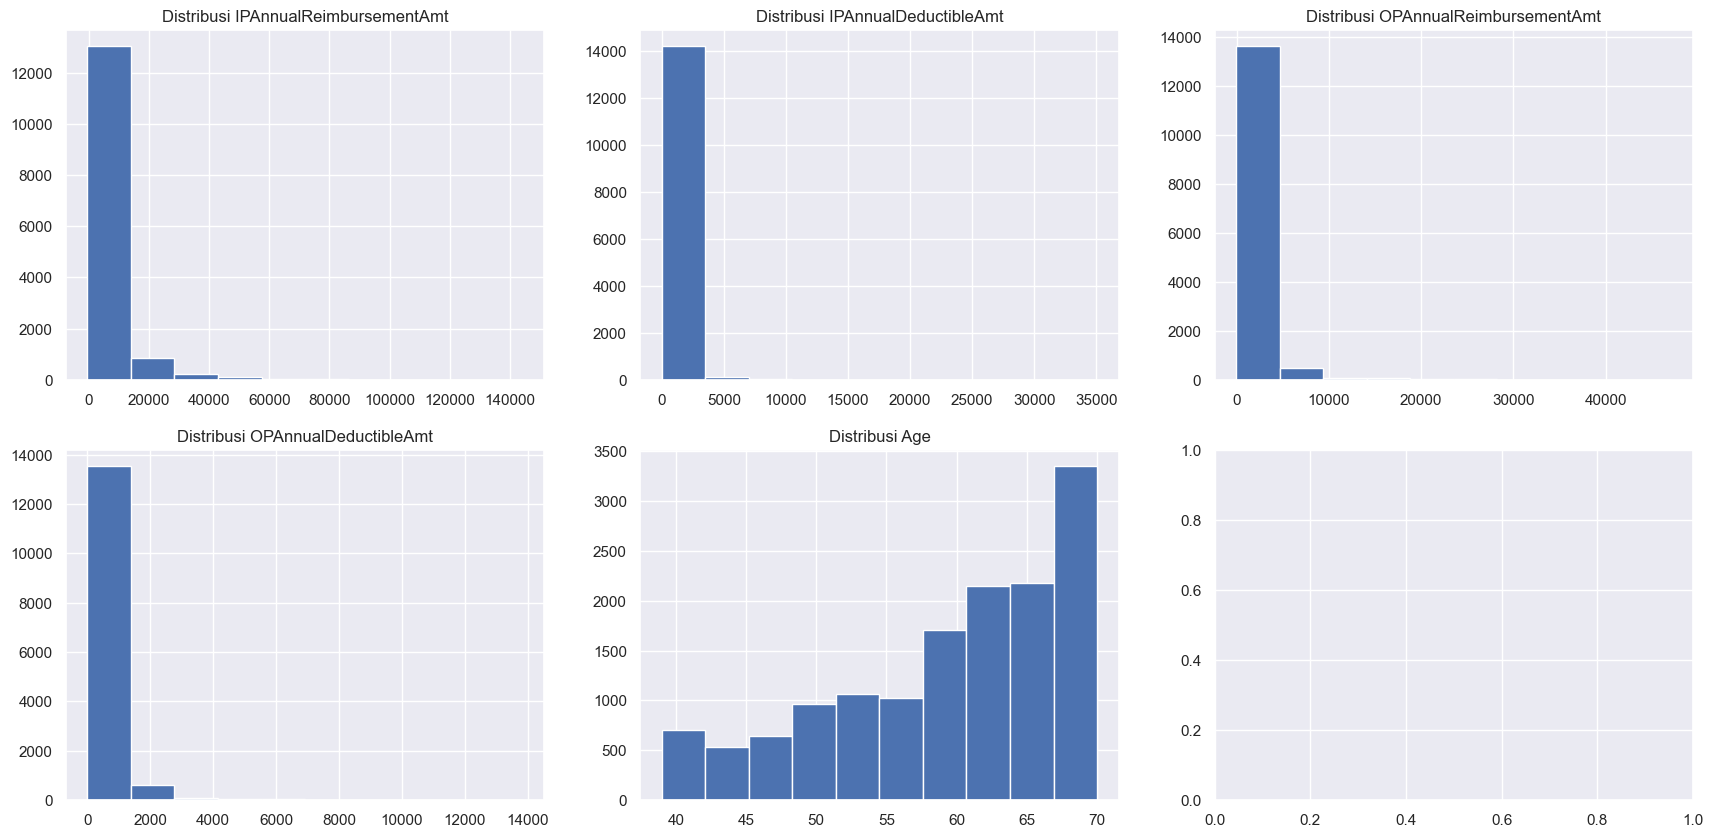

In [26]:
# Check distribution for every features
column_int = benefit.select_dtypes('int64').columns.to_list()
index_int = 0

fig,ax = plt.subplots(2,3, figsize=(21,10))
for row in range(2):
    for col in range(3):
        ax[row,col].hist(benefit[column_int[index_int]])
        ax[row,col].set_title(f"Distribusi {column_int[index_int]}")
        index_int += 1
plt.show()

#### 3.2 Check OP Annual Deductible Toward each variable

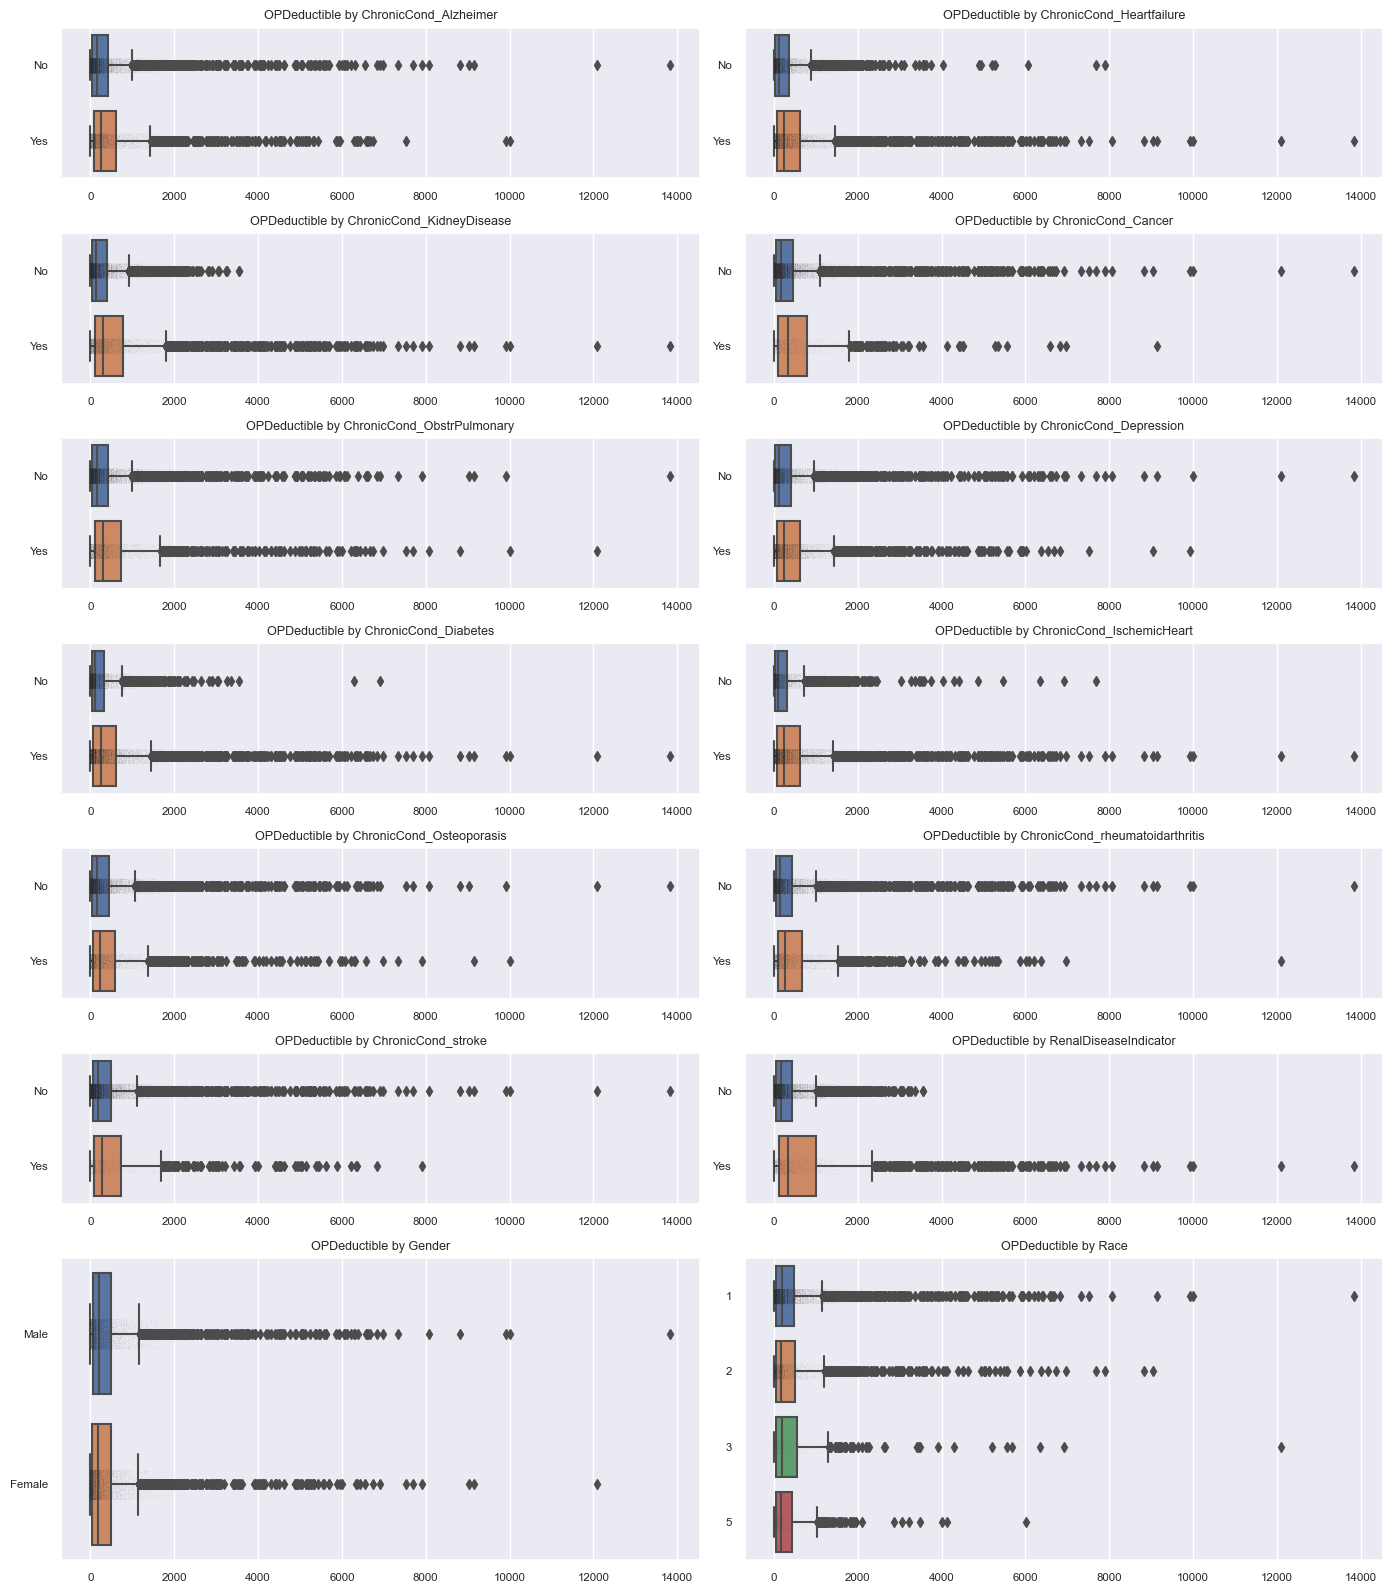

In [ ]:
# Cek distribution by boxplot of each feature
fig, ax = plt.subplots(7,2, figsize=(14,16), gridspec_kw={"height_ratios": [1, 1, 1, 1, 1, 1, 2]})

for i, col in enumerate(benefit_col):
    sns.boxplot(data=benefit, x="OPAnnualDeductibleAmt", y=col, ax=ax[i//2, i%2])
    sns.stripplot(data=benefit, x="OPAnnualDeductibleAmt", y=col, ax=ax[i//2, i%2], color=".3", size=0.1)
    ax[i//2, i%2].set_title(f"OPDeductible by {col}")
    ax[i//2, i%2].set_ylabel("")
    ax[i//2, i%2].set_xlabel("")

plt.tight_layout()
plt.show()

#### 3.3 Check Mean for Every Category

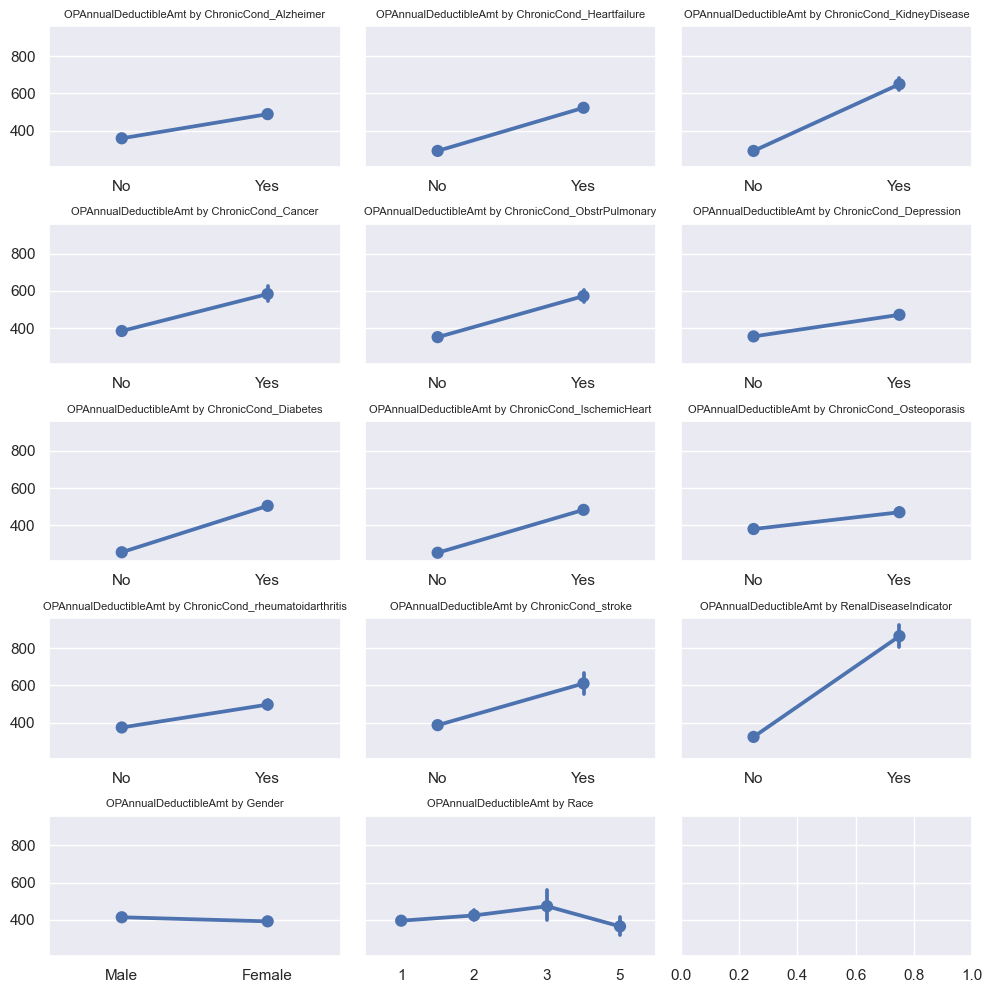

In [27]:
# Rata-rata OPDeductible berdasarkan kategori
fig, ax = plt.subplots(5,3, figsize=(10,10), sharey=True)
sns.set(font_scale=0.75)

for i, col in enumerate(benefit_col):
    sns.pointplot(data = benefit, y = "OPAnnualDeductibleAmt", x = col, ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(f"OPAnnualDeductibleAmt by {col}", fontsize=8)
    ax[i//3, i%3].set_ylabel("")
    ax[i//3, i%3].set_xlabel("")

plt.tight_layout()
plt.show()

#### 3.4 Pearson Correlation

<Axes: >

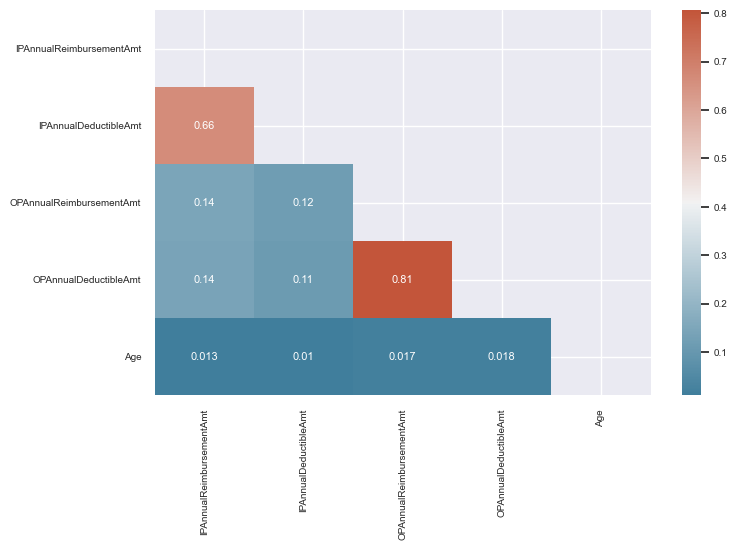

In [28]:
# Heatmap Correlation
sns.set(font_scale=0.65)

corr = benefit[benefit.select_dtypes('int64').columns.to_list()].corr()

fig, ax = plt.subplots(figsize=(8, 5))
mask = np.triu(np.ones_like(corr, dtype= bool))
cmap = sns.diverging_palette(230, 20, as_cmap= True)

sns.heatmap(corr, annot=True, cmap=cmap, mask=mask)

In [29]:
# We are now focusing in OPAnnualDeductible as our target
benefit[["OPAnnualDeductibleAmt","OPAnnualReimbursementAmt","Age"]].corr()

OPAnnualDeductibleAmt  OPAnnualReimbursementAmt   
OPAnnualDeductibleAmt                  1.000000                  0.805787  \
OPAnnualReimbursementAmt               0.805787                  1.000000   
Age                                    0.017878                  0.016589   

                               Age  
OPAnnualDeductibleAmt     0.017878  
OPAnnualReimbursementAmt  0.016589  
Age                       1.000000

#### Highest Mean Difference

In [ ]:
for col in benefit.select_dtypes("object").columns:
    # print(benefit.groupby(col)["OPAnnualDeductibleAmt"].mean())
    print(benefit[col].value_counts())

Gender
Female    7270
Male      7028
Name: count, dtype: int64
Race
1    10368
2     2852
5      556
3      522
Name: count, dtype: int64
RenalDiseaseIndicator
No     12187
Yes     2111
Name: count, dtype: int64
ChronicCond_Alzheimer
No     9468
Yes    4830
Name: count, dtype: int64
ChronicCond_Heartfailure
No     7413
Yes    6885
Name: count, dtype: int64
ChronicCond_KidneyDisease
No     9842
Yes    4456
Name: count, dtype: int64
ChronicCond_Cancer
No     12921
Yes     1377
Name: count, dtype: int64
ChronicCond_ObstrPulmonary
No     10919
Yes     3379
Name: count, dtype: int64
ChronicCond_Depression
No     8355
Yes    5943
Name: count, dtype: int64
ChronicCond_Diabetes
Yes    8473
No     5825
Name: count, dtype: int64
ChronicCond_IschemicHeart
Yes    9336
No     4962
Name: count, dtype: int64
ChronicCond_Osteoporasis
No     10649
Yes     3649
Name: count, dtype: int64
ChronicCond_rheumatoidarthritis
No     10901
Yes     3397
Name: count, dtype: int64
ChronicCond_stroke
No     13233
Ye

<h4><center>The Highest Mean Difference </center></h4>
<center> 1. RenalDiseaseIndicator <center>
<center> 2. ChronicCond_KidneyDisease <center>
<center> 3. ChronicCond_ObstrPulmonary <center>
<center> 4. ChronicCond_stroke <center>
<center> 5. ChronicCond_Diabetes <center>

## **3. Exploratory Data Analysis Part II**
---

#### 3.5 Create Scatterplot to analyze relationship of OP Deductible and OP Reimbursement toward each variable

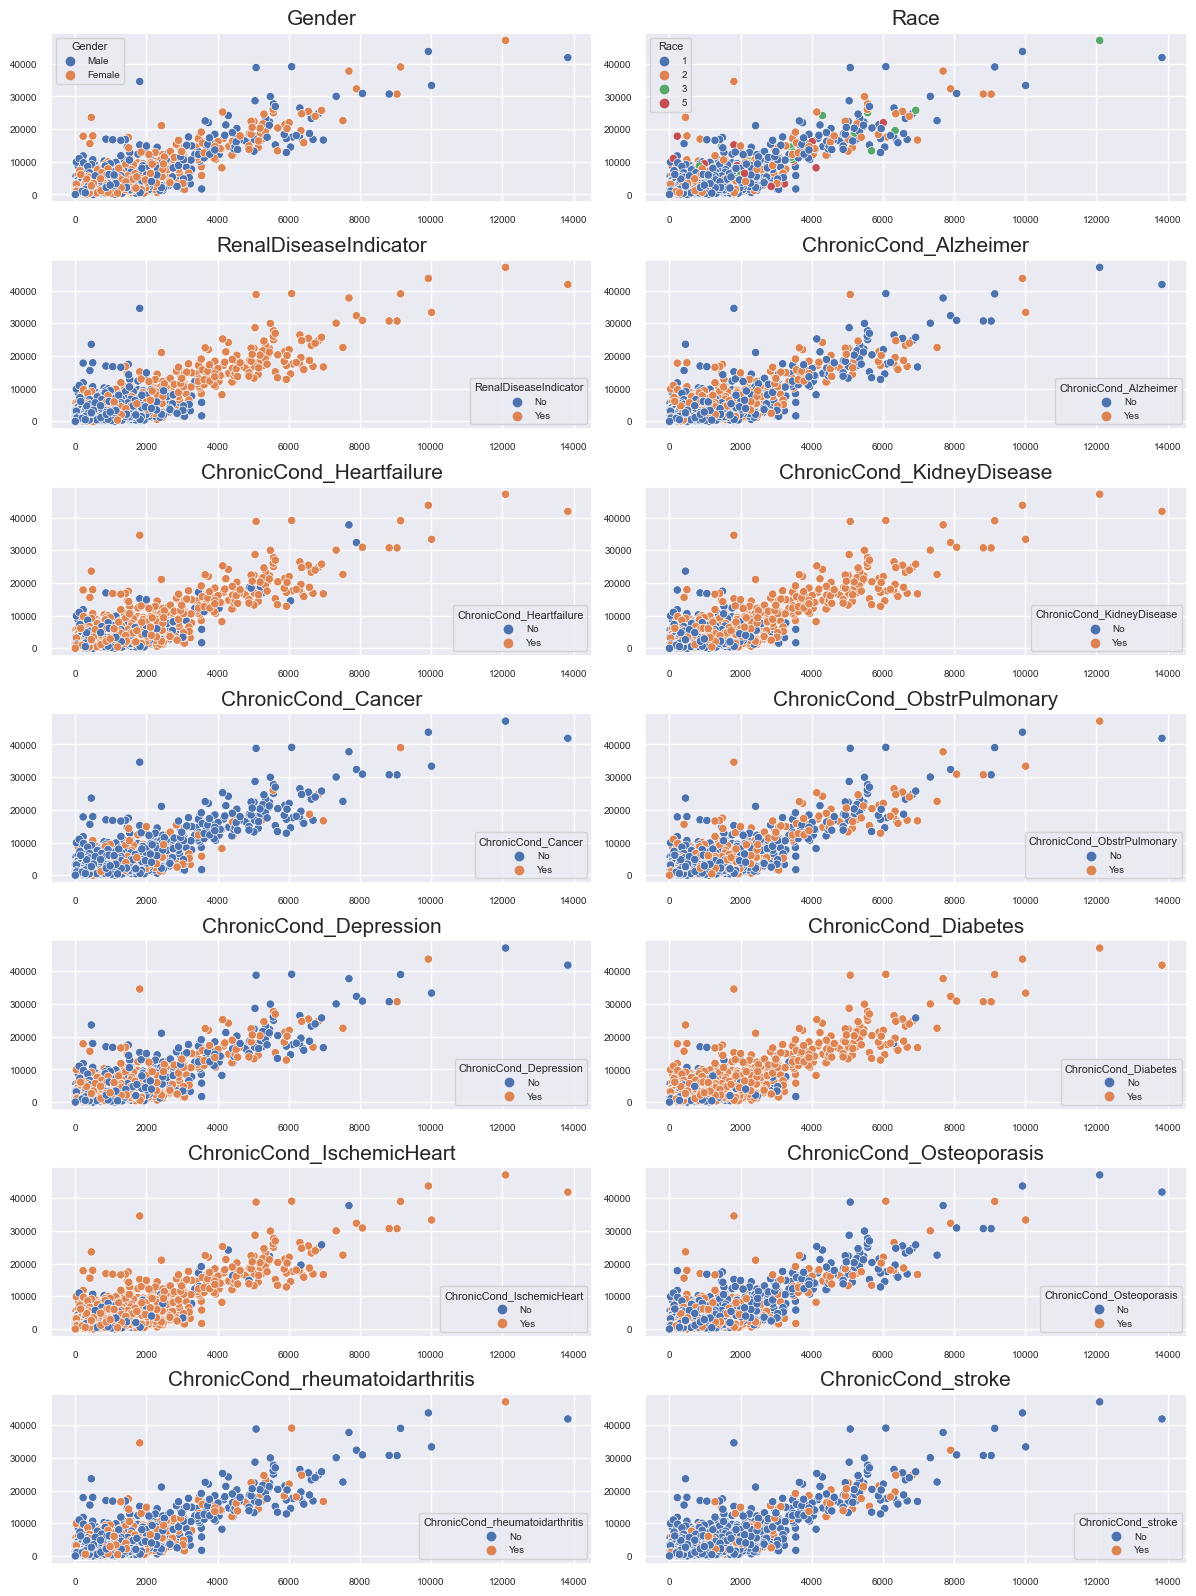

In [30]:
fig, ax = plt.subplots(7,2, figsize=(12,16))

for i, col in enumerate(benefit.select_dtypes('object').columns.to_list()):
    sns.scatterplot(data = benefit, x = "OPAnnualDeductibleAmt", y = "OPAnnualReimbursementAmt", 
                    hue = col, ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f"{col}", fontsize = 15)
    ax[i//2, i%2].set_ylabel("")
    ax[i//2, i%2].set_xlabel("")

plt.tight_layout()
plt.show()

#### 3.6 Create PairPlot to understand data behavior and distribution

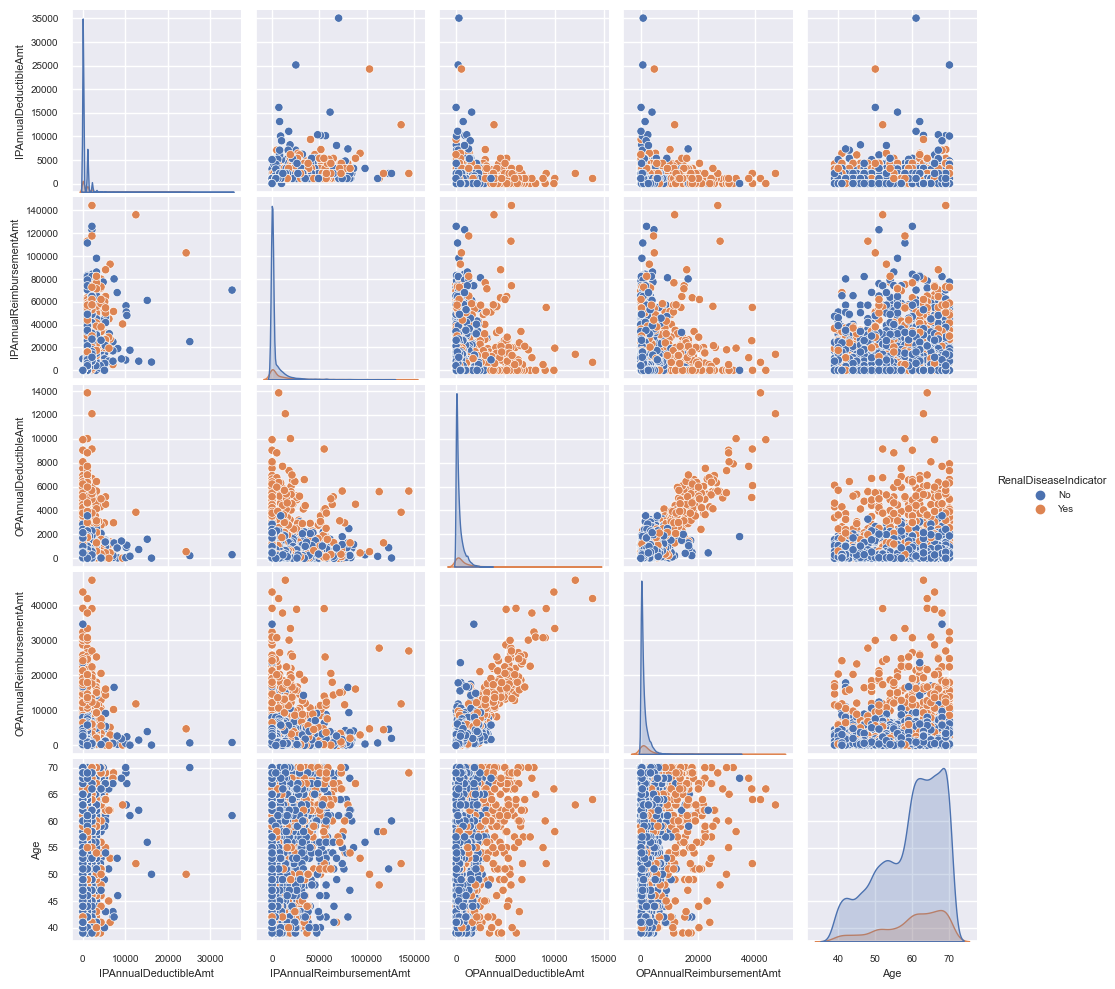

In [ ]:
# Pairplot between categorical

sns.pairplot(data = benefit[["OPAnnualDeductibleAmt","OPAnnualReimbursementAmt","Age","RenalDiseaseIndicator"]], 
             hue = 'RenalDiseaseIndicator', height = 2)

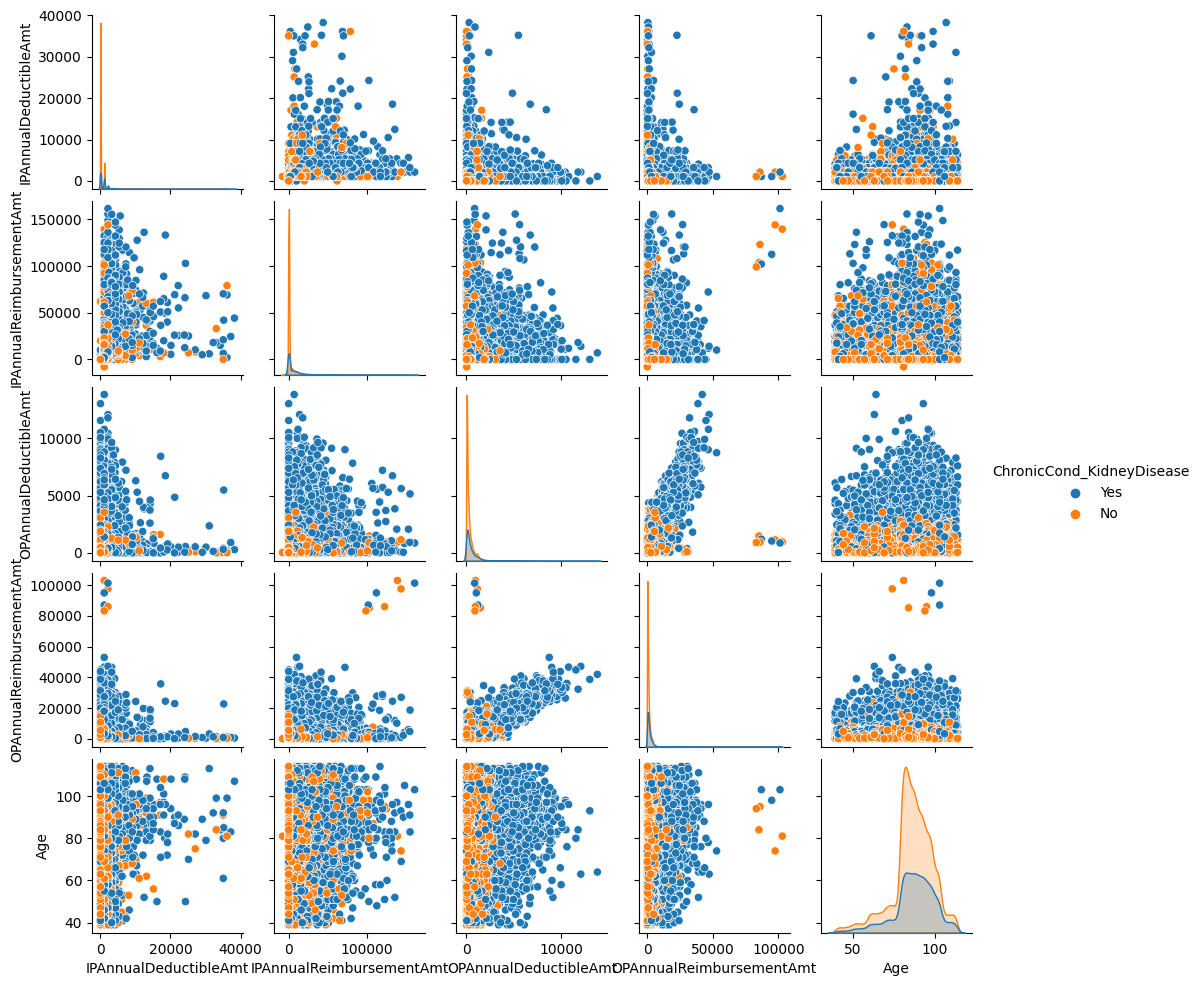

In [ ]:
# Pairplot between categorical

sns.pairplot(data = benefit[["IPAnnualDeductibleAmt","IPAnnualReimbursementAmt","OPAnnualDeductibleAmt",
                             "OPAnnualReimbursementAmt","Age","ChronicCond_KidneyDisease"]], 
             hue = 'ChronicCond_KidneyDisease', height = 2)

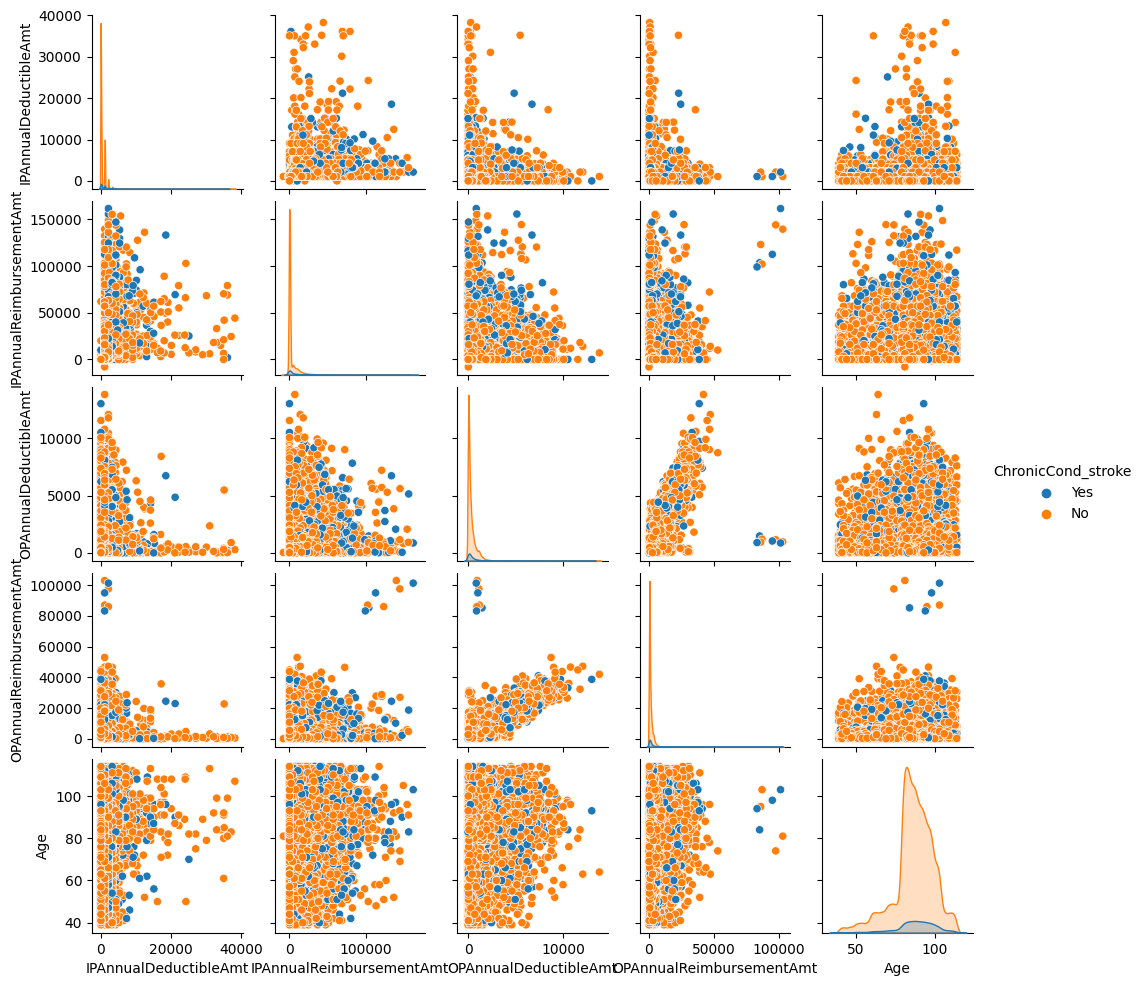

In [ ]:
# Pairplot between categorical

sns.pairplot(data = benefit[["IPAnnualDeductibleAmt","IPAnnualReimbursementAmt","OPAnnualDeductibleAmt",
                             "OPAnnualReimbursementAmt","Age","ChronicCond_stroke"]], 
             hue = 'ChronicCond_stroke', height = 2)

## **4. Statistical Inference of T-Test or Z-Test**
---

##### Create Z-test Function

In [31]:
# Function to calculate Z-Test One Sample
def calculate_ztest(sample, populasi, alpha, alternative = "larger"):
    """
    Calculate z-test one sample.
    sample: sample data
    populasi: populasi data
    alpha: nilai alpha
    alternative: larger (default)

    return result and proportion
    """
    import numpy as np
    import scipy

    xbar = sample.mean()
    mu0 = populasi.mean()
    n = sample.count()
    std_populasi = populasi.std()

    z_stat = (xbar - mu0)/(std_populasi/np.sqrt(n))
    z_crit = scipy.stats.norm.ppf(1-alpha)

    if z_stat > 0:
        p_value = scipy.stats.norm.sf(z_stat) # upper-tailed
    else:
        p_value = scipy.stats.norm.cdf(z_stat) # lower-tailed

    if(p_value <  alpha):
        print(f'Reject H0, p-value : {p_value} < alpha')
    else:
        print(f"Failed to Reject H0, p-value: {p_value:.4f} > alpha")

    if alternative == 'larger':
        if(z_stat > z_crit):
            print(f'reject H0, z-stat > z-crit : {z_stat} > {z_crit}')
        else:
            print(f'Failed reject H0, z-stat < z-crit then : {z_stat} < {z_crit}')
    else:
        if(z_stat < z_crit):
            print(f'reject H0, z-stat < z-crit : {z_stat} > {z_crit}')
        else:
            print(f'Failed reject H0, z-stat > z-crit then : {z_stat} < {z_crit}')

    # Visualization
    import numpy as np
    import matplotlib.pyplot as plt

    # Plot sample
    x = np.arange(-10, 10, 0.01)
    plt.plot(x, scipy.stats.norm.pdf(x, 0, 1), 
            color='blue')
    
    # plot pvalue
    x_pvalue = np.arange(z_stat, 10, 0.01)
    y_pvalue = scipy.stats.norm.pdf(x_pvalue)
    plt.fill_between(x = x_pvalue, 
                    y1 = y_pvalue,
                    facecolor = 'green',
                    alpha = 0.35, 
                    label = 'pvalue')

    # plot alpha region
    x_alpha = np.arange(z_crit, 10, 0.01)
    y_alpha = scipy.stats.norm.pdf(x_alpha)
    plt.fill_between(x = x_alpha, 
                    y1 = y_alpha,
                    facecolor = 'red',
                    alpha = 0.35, 
                    label = 'alpha')

    # plot z-crit and z-stats
    plt.axvline(np.round(z_stat, 4), 
                color ="green", 
                linestyle = "--", 
                label ="z-stat")
    plt.axvline(z_crit, 
                color ="red", 
                linestyle = "--", 
                label ="z-crit")

    plt.legend(loc='best')
    plt.xlabel("z")
    plt.ylabel("density")

    plt.title(f'Standard Normal Distribution Plot \n\n z-statistic = {np.round(z_stat, 4)}, z_crit = {np.round(z_crit, 4)}, p-val = {np.round(p_value, 4)}, alpha = 0.05');

##### Create T-Test Two Sample Function

In [83]:
# Calculate T-Test Two Sample
def calculate_ttest(x1, x2, alpha, alternative = "greater"):
    """
    Calculate t-test two sample.
    sample: sample data
    populasi: populasi data
    alpha: nilai alpha
    alternative: larger (default)

    return result and proportion
    """
    import numpy as np
    import scipy
    from scipy.stats import ttest_ind, levene, kruskal

    x1_mean = x1.mean()
    x2_mean = x2.mean()
    x1_sample = x1.count()
    x2_sample = x2.count()
    degree = x1_sample + x2_sample - 2

    if alternative == "greater":
        t_stat, p_value = ttest_ind(x1, x2, equal_var = True, random_state = 42, alternative = "greater")
        t_crit = scipy.stats.t.ppf(1-alpha, degree)
    elif alternative == "less":
        t_stat, p_value = ttest_ind(x1, x2, equal_var = True, random_state = 42, alternative = "less")
        t_crit = scipy.stats.t.ppf(alpha, degree)
    elif alternative == "two-sided":
        t_stat, p_value = ttest_ind(x1, x2, equal_var = True, random_state = 42, alternative = "two-sided")
        t_crit = scipy.stats.t.ppf(alpha/2, degree)
    else:
        return None

    # if t_stat > 0:
    #     p_value = scipy.stats.norm.sf(z_stat) # upper-tailed
    # else:
    #     p_value = scipy.stats.norm.cdf(z_stat) # lower-tailed

    if(p_value <  alpha):
        print(f'Reject H0, p-value : {p_value:.4f} < {alpha}')
    else:
        print(f"Failed to Reject H0, p-value: {p_value:.4f} > {alpha}")

    if alternative == 'greater':
        if(t_stat > t_crit):
            print(f'Reject H0, t-stat > t-crit : {t_stat:.4f} > {t_crit:.4f}')
        else:
            print(f'Failed reject H0, t-stat < t-crit then : {t_stat:.4f} < {t_crit:.4f}')
    else:
        if(t_stat < t_crit):
            print(f'Reject H0, t-stat < t-crit : {t_stat:.4f} < {t_crit:.4f}')
        else:
            print(f'Failed reject H0, t-stat > t-crit then : {t_stat:.4f} > {t_crit:.4f}')

    # Visualization
    import numpy as np
    import matplotlib.pyplot as plt

    # Plot sample
    x = np.arange(-10, 10, 0.01)
    plt.plot(x, scipy.stats.norm.pdf(x, 0, 1), 
            color='blue')
    
    if alternative == "greater":
        # plot pvalue
        x_pvalue = np.arange(t_stat, 10, 0.01)
        y_pvalue = scipy.stats.norm.pdf(x_pvalue)
        plt.fill_between(x = x_pvalue, 
                        y1 = y_pvalue,
                        facecolor = 'green',
                        alpha = 0.35, 
                        label = 'pvalue')

        # plot alpha region
        x_alpha = np.arange(t_crit, 10, 0.01)
        y_alpha = scipy.stats.norm.pdf(x_alpha)
        plt.fill_between(x = x_alpha, 
                        y1 = y_alpha,
                        facecolor = 'red',
                        alpha = 0.35, 
                        label = 'alpha')
        
    elif alternative == 'less':
        x_pvalue = np.arange(-10, t_stat, 0.01)
        y_pvalue = scipy.stats.norm.pdf(x_pvalue)
        plt.fill_between(x = x_pvalue, 
                        y1 = y_pvalue,
                        facecolor = 'green',
                        alpha = 0.35, 
                        label = 'pvalue')

        # plot alpha region
        x_alpha = np.arange(-10, t_crit, 0.01)
        y_alpha = scipy.stats.norm.pdf(x_alpha)
        plt.fill_between(x = x_alpha, 
                        y1 = y_alpha,
                        facecolor = 'red',
                        alpha = 0.35, 
                        label = 'alpha')
        
    elif alternative == 'two-sided':
        x_pvalue = np.arange(-10, t_stat, 0.01)
        y_pvalue = scipy.stats.norm.pdf(x_pvalue)
        plt.fill_between(x = x_pvalue, 
                        y1 = y_pvalue,
                        facecolor = 'green',
                        alpha = 0.35, 
                        label = 'pvalue')
        
        x_pvalue = np.arange(t_stat, 10, 0.01)
        y_pvalue = scipy.stats.norm.pdf(x_pvalue)
        plt.fill_between(x = x_pvalue, 
                        y1 = y_pvalue,
                        facecolor = 'green',
                        alpha = 0.35)

        # plot alpha region
        x_alpha = np.arange(-10, t_crit, 0.01)
        y_alpha = scipy.stats.norm.pdf(x_alpha)
        plt.fill_between(x = x_alpha, 
                        y1 = y_alpha,
                        facecolor = 'red',
                        alpha = 0.35, 
                        label = 'alpha')
        
        # plot alpha region
        x_alpha = np.arange(-(t_crit), 10, 0.01)
        y_alpha = scipy.stats.norm.pdf(x_alpha)
        plt.fill_between(x = x_alpha, 
                        y1 = y_alpha,
                        facecolor = 'red',
                        alpha = 0.35)

    # plot z-crit and z-stats
    plt.axvline(np.round(t_stat, 4), 
                color ="green", 
                linestyle = "-", 
                label ="t-stat")
    plt.axvline(t_crit, 
                color ="red", 
                linestyle = "--", 
                label ="t-crit")
    plt.axvline(-(t_crit), 
                color ="red", 
                linestyle = "--")

    plt.legend(loc='best')
    plt.xlabel("t")
    plt.ylabel("density")

    plt.title(f'Standard Normal Distribution Plot \n\n t-statistic = {np.round(t_stat, 4)}, t_crit = {np.round(t_crit, 4)}, p-val = {np.round(p_value, 4)}, alpha = 0.05');

#### **4.1 hypothesis test on OP Deductible Renal Disease Indicator** 

In [33]:
print("Apakah OPDeductible Amount untuk Renal Disease Indicator Y lebih tinggi?")
print("")
print("Mari inisiasi nilai alpha dan Jumlah sample")
# inisiasi nilai alpha
alpha = 0.05

# Tentukan sample
benefit_renal_y = benefit["OPAnnualDeductibleAmt"][benefit["RenalDiseaseIndicator"]=="Yes"]

# Tentukan populasi
benefit_renal_n = benefit["OPAnnualDeductibleAmt"][benefit["RenalDiseaseIndicator"]=="No"]

print("="*60)
print(f"Nilai alpha: {alpha}")
print(f"jumlah sample: {benefit_renal_y.count()}")
print(f"std populasi: {benefit_renal_n.count()}")
print("")
print("Berdasarkan jumlah sample > 30 dan std populasi diketahui maka dapat digunakan z-test one sample")

Apakah OPDeductible Amount untuk Renal Disease Indicator Y lebih tinggi?

Mari inisiasi nilai alpha dan Jumlah sample
Nilai alpha: 0.05
jumlah sample: 2111
std populasi: 12187

Berdasarkan jumlah sample > 30 dan std populasi diketahui maka dapat digunakan z-test one sample


In [34]:
print("OPDeductible untuk Renal Disease Indicator Yes lebih rendah atau sama dengan Renal Disease Indicator No")
print("Null hypothesis (ho): μ <= μ0")
print("")
print("Alternative hypothesis (h1): μ > μ0")
print("")
print("Uji pihak kanan")

OPDeductible untuk Renal Disease Indicator Yes lebih rendah atau sama dengan Renal Disease Indicator No
Null hypothesis (ho): μ <= μ0

Alternative hypothesis (h1): μ > μ0

Uji pihak kanan


##### Calculate T-Test Two Sample

Reject H0, p-value : 0.0000 < 0.05
Reject H0, t-stat > t-crit : 34.9340 > 1.6450


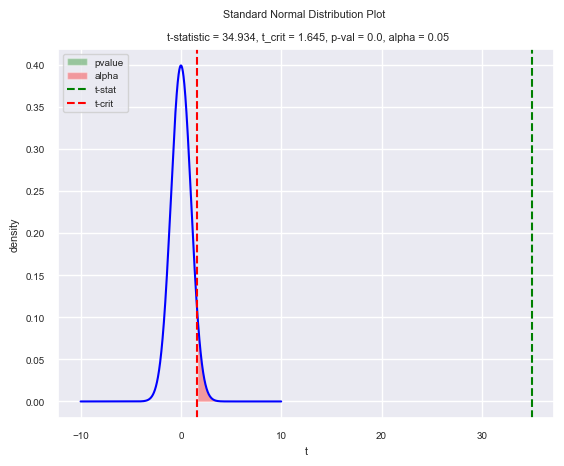

In [35]:
calculate_ttest(x1 = benefit_renal_y, x2= benefit_renal_n, alpha = 0.05)

#### **4.2 hypothesis test on OP Deductible Kidney Disease** 

##### Uji Statistik untuk Kidney Disease

In [36]:
print("Apakah sesorang dengan Kidney Disease memiliki OP Deductible yg lebih tinggi dibanding tidak?")
print("")
print("="*50)
print("Null Hypothesis (Ho): μ <= μ0")
print("Alternative Hypo (H1): μ > μ0")
print("")
print("Uji Pihak Kanan")


Apakah sesorang dengan Kidney Disease memiliki OP Deductible yg lebih tinggi dibanding tidak?

Null Hypothesis (Ho): μ <= μ0
Alternative Hypo (H1): μ > μ0

Uji Pihak Kanan


In [37]:
# Menentukan test statistik dari jumlah sample dan standar deviasi populasi
benefit_kidney_y = benefit["OPAnnualDeductibleAmt"][benefit["ChronicCond_KidneyDisease"]=="Yes"]
benefit_kidney_n = benefit["OPAnnualDeductibleAmt"][benefit["ChronicCond_KidneyDisease"]=="No"]

print("="*50)
print(f"Jumlah Sample 1: {benefit_kidney_y.count()}")
print(f"Jumlah Sample 2: {benefit_kidney_n.count()}")


Jumlah Sample 1: 4456
Jumlah Sample 2: 9842


Reject H0, p-value : 0.0000 < 0.05
Reject H0, t-stat > t-crit : 29.8853 > 1.6450


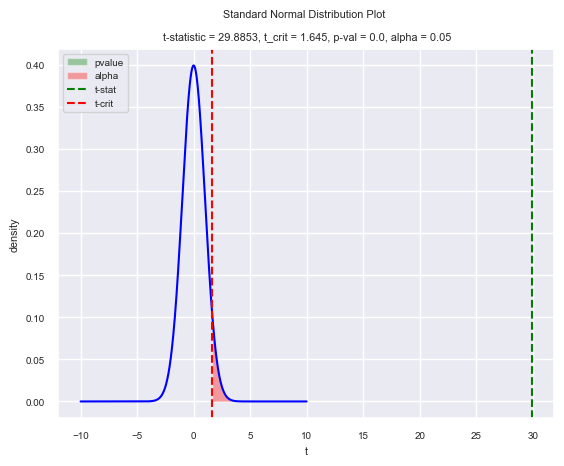

In [38]:
calculate_ttest(x1 = benefit_kidney_y, 
                x2= benefit_kidney_n,
                alpha = 0.05)

#### **4.3 hypothesis test on OP Deductible Cancer Disease** 

In [42]:
print("Apakah sesorang dengan Cancer Disease memiliki OP Deductible yg lebih tinggi dibandingkan dengan yang tidak memiliki Cancer Disease?")
print("")
print("="*50)
print("Null Hypothesis (Ho): μ <= μ0")
print("Alternative Hypo (H1): μ > μ0")
print("")
print("Uji Pihak Kiri")


Apakah sesorang dengan Cancer Disease memiliki OP Deductible yg lebih tinggi dibandingkan dengan yang tidak memiliki Cancer Disease?

Null Hypothesis (Ho): μ <= μ0
Alternative Hypo (H1): μ > μ0

Uji Pihak Kiri


In [43]:
# Menentukan test statistik dari jumlah sample dan standar deviasi populasi
benefit_cancer_y = benefit["OPAnnualDeductibleAmt"][benefit["ChronicCond_Cancer"]=="Yes"]
benefit_cancer_n = benefit["OPAnnualDeductibleAmt"][benefit["ChronicCond_Cancer"]=="No"]

print("="*50)
print(f"Jumlah Sample 1: {benefit_cancer_y.count()}")
print(f"Jumlah Sample 2: {benefit_cancer_n.count()}")


Jumlah Sample 1: 1377
Jumlah Sample 2: 12921


Reject H0, p-value : 0.0000 < 0.05
Reject H0, t-stat > t-crit : 10.2764 > 1.6450


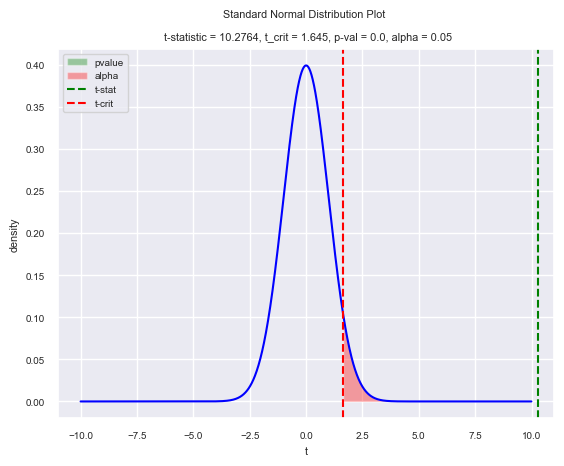

In [44]:
calculate_ttest(x1 = benefit_cancer_y, x2 = benefit_cancer_n, alpha=0.05, alternative='greater')

#### **4.4 hypothesis test on OP Deductible Stroke Disease** 

In [48]:
print("Apakah sesorang dengan Stroke Disease memiliki OP Deductible yg lebih rendah dibandingkan dengan yang tidak memiliki Cancer Disease?")
print("")
print("="*50)
print("Null Hypothesis (Ho): μ <= μ0")
print("Alternative Hypo (H1): μ > μ0")
print("")
print("Uji Pihak Kiri")


Apakah sesorang dengan Stroke Disease memiliki OP Deductible yg lebih rendah dibandingkan dengan yang tidak memiliki Cancer Disease?

Null Hypothesis (Ho): μ <= μ0
Alternative Hypo (H1): μ > μ0

Uji Pihak Kiri


In [49]:
# Menentukan test statistik dari jumlah sample dan standar deviasi populasi
benefit_stroke_y = benefit["OPAnnualDeductibleAmt"][benefit["ChronicCond_stroke"]=="Yes"]
benefit_stroke_n = benefit["OPAnnualDeductibleAmt"][benefit["ChronicCond_stroke"]=="No"]

print("="*50)
print(f"Jumlah Sample 1: {benefit_stroke_y.count()}")
print(f"Jumlah Sample 2: {benefit_stroke_n.std():.2f}")


Jumlah Sample 1: 1065
Jumlah Sample 2: 654.53


Reject H0, p-value : 0.0000 < 0.05
Reject H0, t-stat > t-crit : 10.2997 > 1.6450


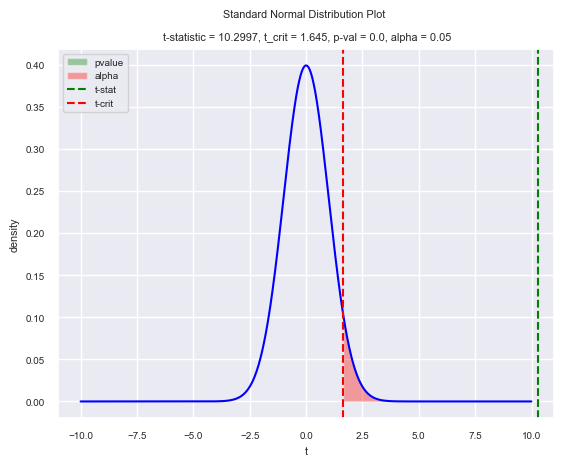

In [69]:
calculate_ttest(x1 = benefit_stroke_y, x2 = benefit_stroke_n, alpha = 0.05, alternative="greater")

#### **4.5 hypothesis test on Gender** 

Failed to Reject H0, p-value: 0.0555 > 0.05
Failed reject H0, t-stat > t-crit then : 1.9154 > -1.9601


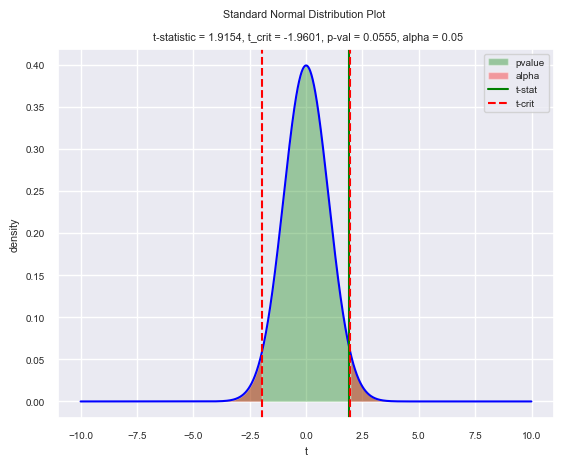

In [84]:
calculate_ttest(x1 = benefit["OPAnnualDeductibleAmt"][benefit["Gender"]=="Male"], 
                x2= benefit["OPAnnualDeductibleAmt"][benefit["Gender"]=="Female"], 
                alpha = 0.05,
                alternative="two-sided")

## **5. Modelling**
---

In [96]:
for col in benefit_col:
    benefit[col] = benefit[col].replace({"Yes":0,"No":1,"Female":0,"Male":1})

##### **5.1 Cross Validation**

In [184]:
# Create a class model
ols_OP = StatsmodelsRegressor(smf.ols, "OPAnnualDeductibleAmt ~ OPAnnualReimbursementAmt + ChronicCond_KidneyDisease + ChronicCond_Cancer + RenalDiseaseIndicator + ChronicCond_Diabetes")

In [185]:
# Create k-fold splitter object

kfold = KFold(n_splits=5, shuffle = True, random_state=123)

In [189]:
scores_ols_op = cross_val_score(estimator= ols_OP,
                                     X = benefit,
                                     y = benefit["OPAnnualDeductibleAmt"],
                                     cv = kfold,
                                     scoring = "r2")

scores_ols_op = pd.DataFrame(data = scores_ols_op, columns=["test_rsquared"])
scores_ols_op["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_op["test_rsquared"].mean()

0.6541311992180819

In [187]:
scores_ols_op

test_rsquared    folds
0       0.659198  Folds 1
1       0.672636  Folds 2
2       0.653624  Folds 3
3       0.648523  Folds 4
4       0.636675  Folds 5

##### **5.2 Model Fitting using SMF**

In [190]:
model_ = smf.ols("OPAnnualDeductibleAmt ~ OPAnnualReimbursementAmt + ChronicCond_KidneyDisease + ChronicCond_Cancer + ChronicCond_Diabetes + RenalDiseaseIndicator", 
                benefit[["OPAnnualDeductibleAmt","OPAnnualReimbursementAmt","ChronicCond_KidneyDisease","ChronicCond_Cancer","RenalDiseaseIndicator","ChronicCond_Diabetes"]])

results_op = model_.fit()

results_op_ins = print_coef_std(results_op)
results_op_ins

coef  std_error
Intercept                  274.386494  14.017245
OPAnnualReimbursementAmt     0.210152   0.001395
ChronicCond_KidneyDisease  -41.440701   8.505600
ChronicCond_Cancer         -48.028250  11.543975
ChronicCond_Diabetes       -33.944168   7.313301
RenalDiseaseIndicator      -85.787393  10.795950

In [191]:
results_op.rsquared

0.6548308298745588

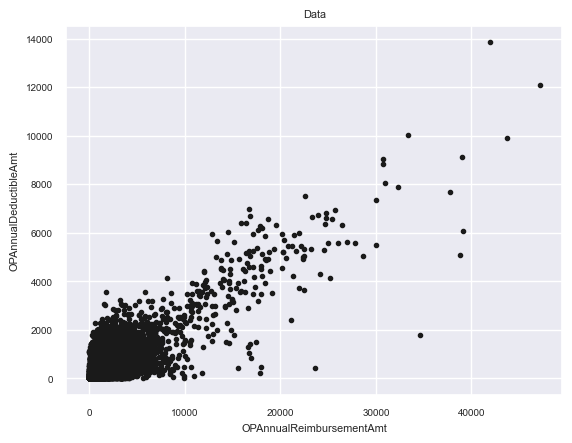

In [143]:
x = benefit['OPAnnualReimbursementAmt']
y = benefit['OPAnnualDeductibleAmt']

# Plot the data
plt.scatter(x, y, color = "k", marker=".")

# Add a legend and labels

plt.xlabel("OPAnnualReimbursementAmt")
plt.ylabel("OPAnnualDeductibleAmt")

# Add a title and adjust the margins
plt.title("Data")

# Show the plot
plt.show()

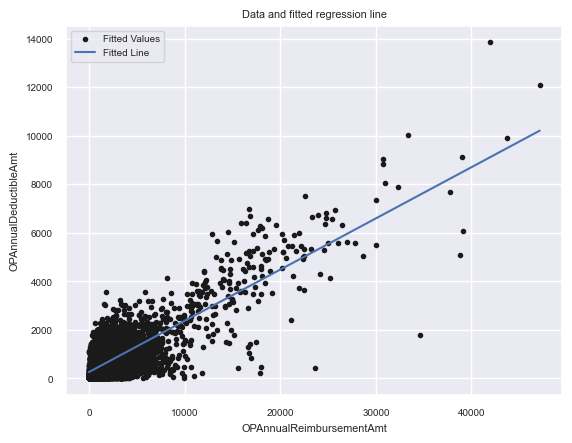

In [151]:
predictor = "OPAnnualReimbursementAmt"
outcome = "OPAnnualDeductibleAmt"
data = benefit.copy()
results_ = results_op_ins.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
plt.legend(["Fitted Values",
           "Fitted Line"])
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

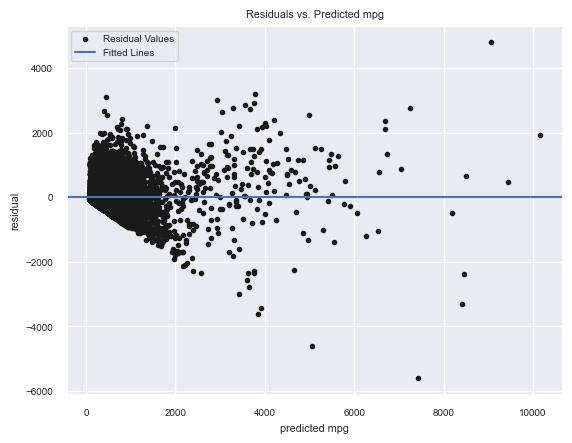

In [153]:
plt.scatter(results_op.fittedvalues, results_op.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.legend(["Residual Values", "Fitted Lines"])
plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

##### **5.3 INTERACTION**

In [192]:
model_interaction = smf.ols("OPAnnualDeductibleAmt ~ OPAnnualReimbursementAmt + ChronicCond_KidneyDisease + OPAnnualReimbursementAmt:ChronicCond_KidneyDisease", 
                benefit[["OPAnnualDeductibleAmt","OPAnnualReimbursementAmt","ChronicCond_KidneyDisease"]])

results_op_interaction = model_interaction.fit()

results_op_interaction_ins = print_coef_std(results_op_interaction)
print(results_op_interaction_ins)
print("")
print(f"Rsquared: {results_op_interaction.rsquared:.4f}")

                                                          coef  std_error
Intercept                                           133.015489   6.833719
OPAnnualReimbursementAmt                              0.228741   0.001498
ChronicCond_KidneyDisease                            12.807577   8.430613
OPAnnualReimbursementAmt:ChronicCond_KidneyDisease   -0.077925   0.003358

Rsquared: 0.6649


In [155]:
results_op_interaction.rsquared

0.6648533087561335

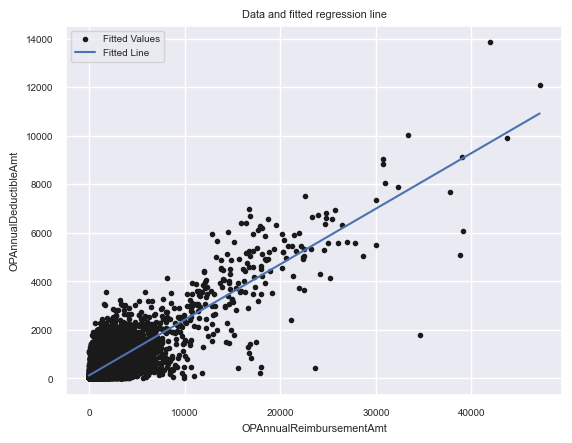

In [156]:
predictor = "OPAnnualReimbursementAmt"
outcome = "OPAnnualDeductibleAmt"
data = benefit.copy()
results_ = results_op_interaction_ins.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
plt.legend(["Fitted Values",
           "Fitted Line"])
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

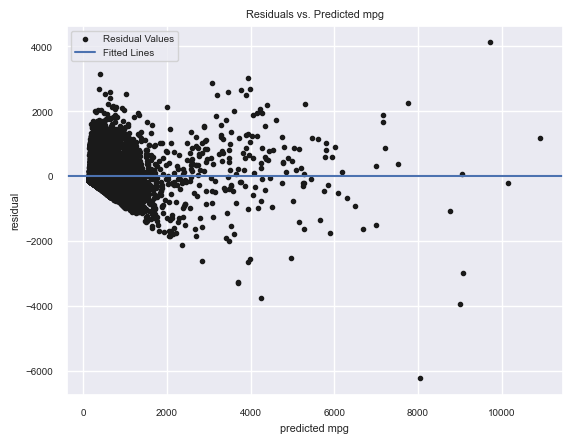

In [157]:
plt.scatter(results_op_interaction.fittedvalues, results_op_interaction.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.legend(["Residual Values", "Fitted Lines"])
plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

In [176]:
model_interaction_2 = smf.ols("OPAnnualDeductibleAmt ~ OPAnnualReimbursementAmt + RenalDiseaseIndicator + OPAnnualReimbursementAmt:RenalDiseaseIndicator", 
                benefit[["OPAnnualDeductibleAmt","OPAnnualReimbursementAmt","RenalDiseaseIndicator"]])

results_op_interaction_2 = model_interaction_2.fit()

results_op_interaction_ins_2 = print_coef_std(results_op_interaction_2)
print(results_op_interaction_ins_2)
print("")
print(f"Rsquared : {results_op_interaction_2.rsquared:.4f}")

                                                      coef  std_error
Intercept                                       130.858778   9.855467
OPAnnualReimbursementAmt                          0.238859   0.001612
RenalDiseaseIndicator                            28.407591  10.789092
OPAnnualReimbursementAmt:RenalDiseaseIndicator   -0.086180   0.002900

Rsquared : 0.6729


In [168]:
results_op_interaction_2.rsquared

0.6729111034103917

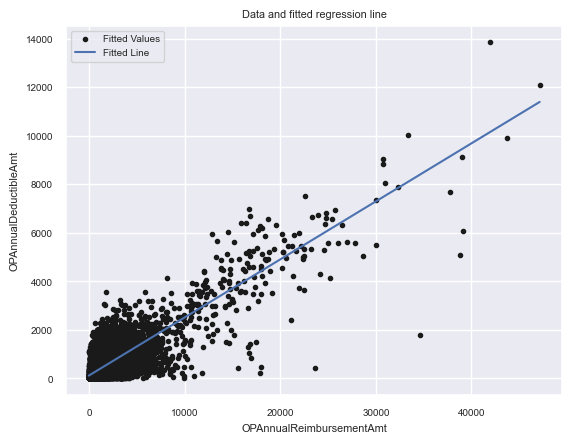

In [169]:
predictor = "OPAnnualReimbursementAmt"
outcome = "OPAnnualDeductibleAmt"
data = benefit.copy()
results_ = results_op_interaction_ins_2.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
plt.legend(["Fitted Values",
           "Fitted Line"])
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

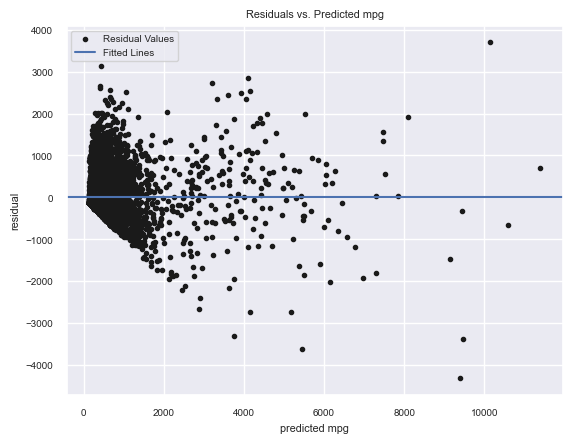

In [170]:
plt.scatter(results_op_interaction_2.fittedvalues, results_op_interaction_2.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.legend(["Residual Values", "Fitted Lines"])
plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")

### Transformation
---

#### Log_Transformation

In [162]:
benefit["log_OPAnnualDeductibleAmt"] = np.log(benefit["OPAnnualDeductibleAmt"][benefit["OPAnnualDeductibleAmt"]>0])
benefit["log_OPAnnualReimbursementAmt"] = np.log(benefit["OPAnnualReimbursementAmt"][benefit["OPAnnualReimbursementAmt"]>0])

model_renal_log = smf.ols("log_OPAnnualDeductibleAmt ~ log_OPAnnualReimbursementAmt + RenalDiseaseIndicator", benefit)

model_renal_log = model_renal_log.fit()

results_renal_ins_log = print_coef_std(model_renal_log)
print(results_renal_ins_log)
print("")
print(f"Rsquared : {model_renal_log.rsquared}")

                                  coef  std_error
Intercept                     1.431076   0.055510
log_OPAnnualReimbursementAmt  0.625196   0.007019
RenalDiseaseIndicator        -0.248759   0.026731

Rsquared : 0.4029638680741504


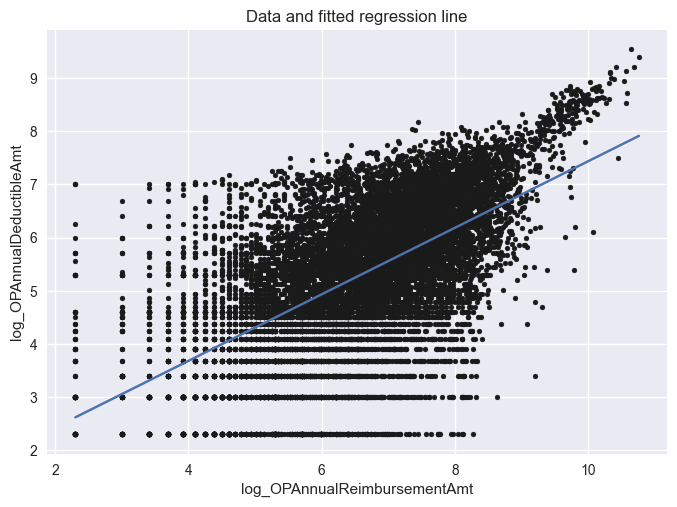

In [244]:
predictor = "log_OPAnnualReimbursementAmt"
outcome = "log_OPAnnualDeductibleAmt"
data = benefit.copy()
results_ = results_renal_ins_log.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
# plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

#### Standardization_Transform

In [194]:
benefit["T_OPAnnualDeductibleAmt"] = ( benefit["OPAnnualDeductibleAmt"] - benefit["OPAnnualDeductibleAmt"].mean() ) / benefit["OPAnnualDeductibleAmt"].std()
benefit["T_OPAnnualReimbursementAmt"] = ( benefit["OPAnnualReimbursementAmt"] - benefit["OPAnnualReimbursementAmt"].mean() ) / benefit["OPAnnualReimbursementAmt"].std()

model_T = smf.ols("T_OPAnnualDeductibleAmt ~ T_OPAnnualReimbursementAmt + ChronicCond_KidneyDisease + ChronicCond_Cancer + ChronicCond_Diabetes + RenalDiseaseIndicator", 
                        benefit[["T_OPAnnualDeductibleAmt","T_OPAnnualReimbursementAmt","ChronicCond_KidneyDisease","ChronicCond_Cancer","ChronicCond_Diabetes","RenalDiseaseIndicator"]])

model_T = model_T.fit()

results_ins_T = print_coef_std(model_T)
print(results_ins_T)
print("")
print(f"Rsquared : {model_T.rsquared:.4f}")

                                coef  std_error
Intercept                   0.232082   0.019676
T_OPAnnualReimbursementAmt  0.781144   0.005187
ChronicCond_KidneyDisease  -0.060535   0.012425
ChronicCond_Cancer         -0.070157   0.016863
ChronicCond_Diabetes       -0.049584   0.010683
RenalDiseaseIndicator      -0.125314   0.015770

Rsquared : 0.6548


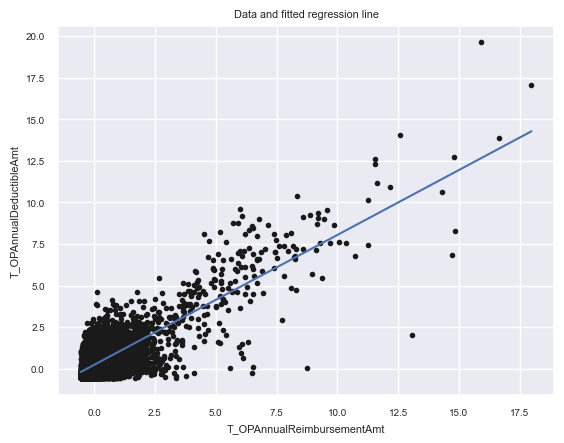

In [195]:
predictor = "T_OPAnnualReimbursementAmt"
outcome = "T_OPAnnualDeductibleAmt"
data = benefit.copy()
results_ = results_ins_T.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), 10000)

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
# plt.legend()
plt.ylabel(outcome)
plt.xlabel(predictor)

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

Text(0.5, 1.0, 'Residuals vs. Predicted mpg')

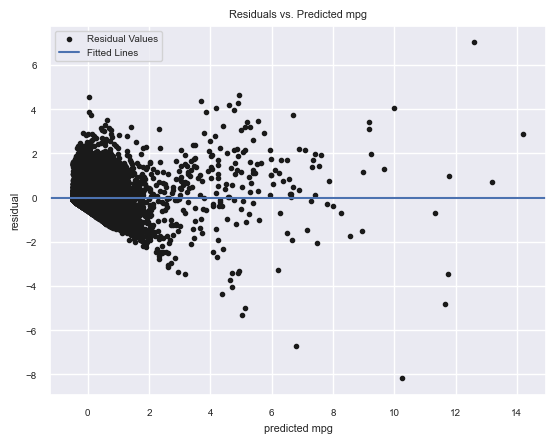

In [196]:
plt.scatter(model_T.fittedvalues, model_T.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.legend(["Residual Values", "Fitted Lines"])
plt.xlabel("predicted mpg")
plt.ylabel("residual")
plt.title(f"Residuals vs. Predicted mpg")